### STATS 202 
Waseh Ahmad
Summer 2019

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
#import statements
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import warnings
from scipy import stats
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,LeaveOneOut
from statsmodels.graphics.gofplots import ProbPlot
from scipy.cluster import hierarchy
from sklearn.preprocessing import normalize,scale
from sklearn.cluster import AgglomerativeClustering


warnings.filterwarnings('ignore')

In [4]:
#load data
files = ['Study_A.csv','Study_B.csv','Study_C.csv','Study_D.csv']
trials = []
for file in files:
    trials.append(pd.read_csv(file))
testDF = pd.read_csv('Study_E.csv')
trialsDF = pd.concat(trials)
# trialsDF.PatientID = pd.factorize(trialsDF.PatientID)[0]
# trialsDF.Country = pd.factorize(trialsDF.Country)[0]

# trialsDF.corr().style.background_gradient(cmap='coolwarm')
# plt.scatter(trialsDF.PatientID,trialsDF.SiteID)

In [5]:
#add constant term
trialsDF = sm.add_constant(trialsDF)
#creat a dataframe sorted by patient id and by visit day
sortedDF = trialsDF.sort_values(['PatientID', 'VisitDay'], ascending=[True, True])
# reset the index for the different trials
sortedDF = sortedDF.reset_index()

def GetLaggedDiff(df,resultColumn,varColumn):
    currId = prevId = -1
    prevRow = []
    visitDay = 0;
    for index,row in df.iterrows():
        currId = int(row['PatientID'])
        if(currId != prevId):
            df.at[index,resultColumn] = 0
            df.at[index,'VisitDay'] = 0
            visitDay=0;
        else:
            visitDay +=1
            df.at[index,'VisitDay'] = visitDay
            df.at[index,resultColumn] = row[varColumn] - prevRow[varColumn]
        prevRow = row
        prevId = currId
    return df

df= sortedDF
df['Ps'] = sortedDF.P1 + sortedDF.P2 + sortedDF.P3+ sortedDF.P4+ sortedDF.P5+ sortedDF.P6+ sortedDF.P7
df['Ns'] = sortedDF.N1 + sortedDF.N2 + sortedDF.N3+ sortedDF.N4+ sortedDF.N5+ sortedDF.N6+ sortedDF.N7
df['Gs'] = sortedDF.G1 + sortedDF.G2 + sortedDF.G3+ sortedDF.G4+ sortedDF.G5+ sortedDF.G6+ sortedDF.G7 + sortedDF.G8 + sortedDF.G9 + sortedDF.G10+ sortedDF.G11+ sortedDF.G12+ sortedDF.G13+ sortedDF.G14 + sortedDF.G15 +sortedDF.G16 

sortedDF = GetLaggedDiff(sortedDF,'PANSS_Total_diff','PANSS_Total')
prunedDF = sortedDF.loc[sortedDF['LeadStatus'] == 'Passed']

In [155]:
groupedDF = pd.DataFrame({'TxGroup':sortedDF.groupby('PatientID').TxGroup.agg(pd.Series.mode),'PANSS_diff_avg':sortedDF.groupby('PatientID').mean().PANSS_Total_diff})
formula = "PANSS_diff_avg~ C(TxGroup)"
olsModelDiff = smf.ols(formula,data=groupedDF).fit()
olsModelDiff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PANSS_diff_avg   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.04354
Date:                Sun, 28 Jul 2019   Prob (F-statistic):              0.835
Time:                        23:54:02   Log-Likelihood:                -5811.0
No. Observations:                2434   AIC:                         1.163e+04
Df Residuals:                    2432   BIC:                         1.164e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.8570      0.075    -24.656      0.000      -2.005      -1.709
C(TxGroup)[T.Treatment]    -0.0223      0.107     -0.209      0.835      -0.232       0.187
==============================================================================
Omnibus:                      377.363   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6289.157
Skew:                          -0.027   Prob(JB):                         0.00
Kurtosis:                      10.875   Cond. No.                         2.61
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Patient Segmentation

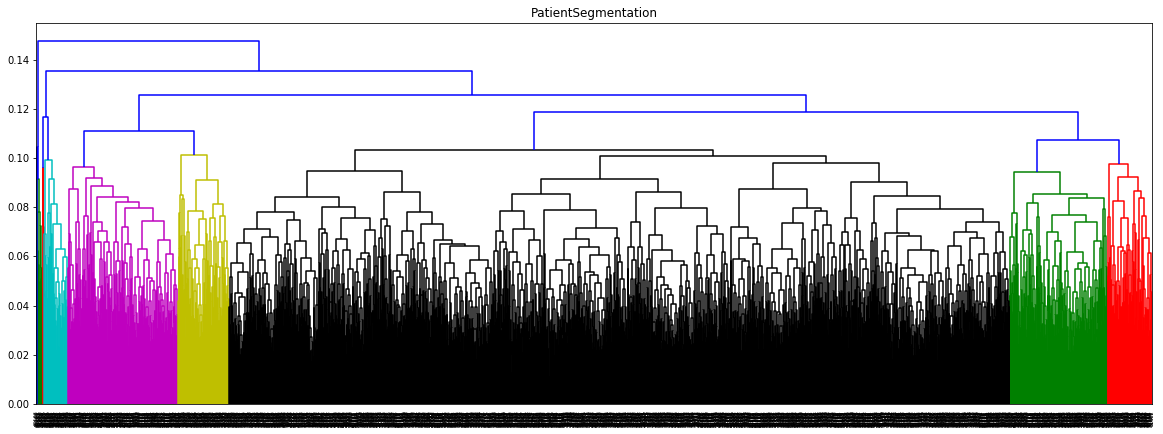

In [6]:
firstVisits = sortedDF.groupby('PatientID').first().drop(['index','const','Study','TxGroup','SiteID','RaterID','AssessmentiD','LeadStatus','Country','VisitDay','PANSS_Total_diff'],axis = 1)
# firstVisits['Country'] = pd.factorize(firstVisits['Country'])[0]

data_scaled = normalize(firstVisits,axis=0)
data_scaled = pd.DataFrame(data_scaled, columns=firstVisits.columns)


labels = firstVisits.index.values
linked = hierarchy.linkage(data_scaled, 'complete',metric='euclidean')

plt.figure(figsize=(20, 7))  
arrestsDendrogram = hierarchy.dendrogram(linked,labels=labels)
plt.title("PatientSegmentation")
plt.axhline(y=0.3, color='r', linestyle='--')
plt.show() 


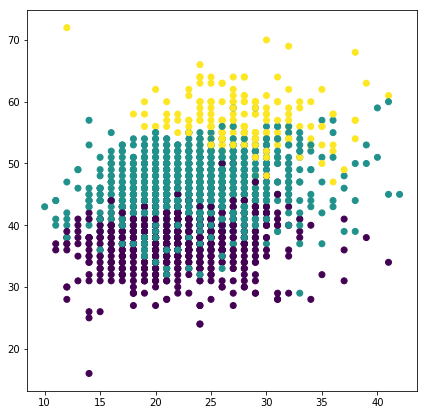

In [7]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')  
clusters = cluster.fit_predict(firstVisits)
firstVisits['Segment'] = clusters
plt.figure(figsize=(7, 7))  
# for seg in range(4):
#     (firstVisits.loc[firstVisits['Segment'] == seg].boxplot(column=['Ps'],by=['Segment']))
plt.scatter(firstVisits['Ns'], firstVisits['Gs'], c=cluster.labels_) 
# data_scaled

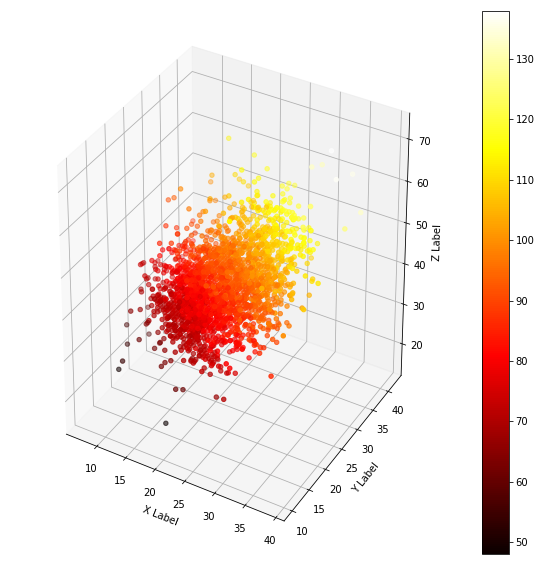

In [10]:
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook
fig = plt.figure(figsize=(10, 10)) 
ax = fig.add_subplot(111, projection='3d')

img = ax.scatter(firstVisits.Ps,firstVisits.Ns, firstVisits.Gs, c=firstVisits.PANSS_Total, cmap=plt.hot(), marker='o')
fig.colorbar(img)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()
